# Medición de impacto de campañas publicitarias de Uber mediante series de tiempo bayesianas

**Elias Buitrago Bolivar** <br>
*Bogotá, Colombia* <br>
*26/mayo/2021* <br>
*Las actualizaciones de este código se encuentran en mi cuenta [github](https://github.com/ebuitrago/BI/blob/main/ARL_accidentes_trabajo/modelo_AT_arboles.ipynb)*

## Cargar librerías

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn import metrics, svm
from sklearn.metrics import recall_score
import graphviz
import seaborn as sns

## Cargar datos
Se leen los archivos de datos formato csv. Inicialmente se tienen disponibles seis archivos con los datos de viajes de Uber desde abril hasta septiembre.

In [3]:
col_names = ['No','Fecha.Hora','Lat','Lon','Categoria','Zona']
datos_abril = pd.read_csv("Datos/datos_abril.csv", skiprows=1, names=col_names)
datos_abril = datos_abril.drop(['No'], axis=1, index=None)
datos_mayo = pd.read_csv("Datos/datos_mayo.csv", skiprows=1, names=col_names)
datos_mayo = datos_mayo.drop(['No'], axis=1)
datos_junio = pd.read_csv("Datos/datos_junio.csv", skiprows=1, names=col_names)
datos_junio = datos_junio.drop(['No'], axis=1)
datos_julio = pd.read_csv("Datos/datos_julio.csv", skiprows=1, names=col_names)
datos_julio = datos_julio.drop(['No'], axis=1)
datos_agosto = pd.read_csv("Datos/datos_agosto.csv", skiprows=1, names=col_names)
datos_agosto = datos_agosto.drop(['No'], axis=1)
datos_septiembre = pd.read_csv("Datos/datos_septiembre.csv", skiprows=1, names=col_names)
datos_septiembre = datos_septiembre.drop(['No'], axis=1)

In [ ]:
# datos = datos_abril
# datos = datos.append(datos_mayo)
# datos = datos.append(datos_junio)
# datos = datos.append(datos_julio)
# datos = datos.append(datos_agosto)
# datos = datos.append(datos_septiembre)

## Transformación datos
A partir de los datos iniciales, se hacen transformaciones parar obtener los datos específicos que permitan analizar los resultados de las dos campañas adelantadas por la empresa.

### Datos campaña Jersey City
Se filtran los datos para seleccionar los viajes de la zona Jersey City. Luego, se hace otro filtrado para extraer los viajes en las horas valle: desde la media noche hasta las once. Finalmente se crea una lista con el conteo del número de viajes diarias en el horario de interés para la campaña.

In [ ]:
# jc_data = datos_abril[['Zona','Fecha.Hora']].groupby('Zona', ).get_group('Jersey City').reset_index(drop=True)

In [4]:
#Esta función se utiliza para filtrar los viajes en la zona de Jersey City y generar un DAtaFrame con los viajes en las horas valle en dicha zona
def cmp1(datos_mes):
    f=[]
    d=[]
    h=[]
    jc_data = datos_mes[(datos_mes.Zona == 'Jersey City')].reset_index(drop=True)
    for i in range(0,len(jc_data)):
        aux = dt.datetime.strptime(jc_data.iloc[i,0], '%m/%d/%Y %H:%M:%S')
        aux2 = aux.hour
        f.insert(i,aux.strftime('%m/%d'))
        h.insert(i,aux2)

    jc_data_cmp1=pd.DataFrame()
    jc_data_cmp1['Fecha'] = f
    jc_data_cmp1['Hora'] = h

    jc_data_cmp1 = jc_data_cmp1[(jc_data_cmp1.Hora <= 11)].reset_index(drop=True)
    serie_cmp1=jc_data_cmp1.groupby('Fecha').count()
    return serie_cmp1

In [5]:
#Esta función se utiliza para filtrar los viajes en cada zona y generar un DataFrame con los viajes distintas a Jersey City y generar un DztaFrame con los viajes en las horas valle en dichas zonas
def cmp1_ref(datos_mes):
    f=[]
    d=[]
    h=[]
    jc_data = datos_mes[(datos_mes.Zona != 'Jersey City')].reset_index(drop=True)
    for i in range(0,len(jc_data)):
        aux = dt.datetime.strptime(jc_data.iloc[i,0], '%m/%d/%Y %H:%M:%S')
        aux2 = aux.hour
        f.insert(i,aux.strftime('%m/%d'))
        h.insert(i,aux2)

    jc_data_cmp1=pd.DataFrame()
    jc_data_cmp1['Fecha'] = f
    jc_data_cmp1['Hora'] = h

    jc_data_cmp1 = jc_data_cmp1[(jc_data_cmp1.Hora <= 11)].reset_index(drop=True)
    serie_cmp1_ref=jc_data_cmp1.groupby('Fecha').count()    
    return serie_cmp1_ref

In [6]:
#Filtrar datos de viajes en horas valle en la zona Jersey City, para analizar la campaña #1
datos_cmp1_abril = cmp1(datos_abril)
datos_cmp1_mayo = cmp1(datos_mayo)
datos_cmp1_junio = cmp1(datos_junio)
datos_cmp1_julio = cmp1(datos_julio)
datos_cmp1_agosto = cmp1(datos_agosto)
datos_cmp1_septiembre = cmp1(datos_septiembre)

#Unificar conjuntos de datos mensuales en un solo DataFrame
datos_cmp1 = datos_cmp1_abril.append(datos_cmp1_mayo)
datos_cmp1 = datos_cmp1.append(datos_cmp1_junio)
datos_cmp1 = datos_cmp1.append(datos_cmp1_julio)
datos_cmp1 = datos_cmp1.append(datos_cmp1_agosto)
datos_cmp1 = datos_cmp1.append(datos_cmp1_septiembre)

In [8]:
datos_cmp1.head()

,Hora
Fecha,
04/01,46
04/02,45
04/03,50
04/04,96
04/05,67


In [15]:
datos_cmp1.to_csv('datos_cmp1.csv')

In [9]:
#Filtrar datos de viajes en horas valle en zonas distintas a Jersey City, como referencias para complementar en análisis de la campaña #1
datos_cmp1Ref_abril = cmp1_ref(datos_abril)
datos_cmp1Ref_mayo = cmp1_ref(datos_mayo)
datos_cmp1Ref_junio = cmp1_ref(datos_junio)
datos_cmp1Ref_julio = cmp1_ref(datos_julio)
datos_cmp1Ref_agosto = cmp1_ref(datos_agosto)
datos_cmp1Ref1_septiembre = cmp1_ref(datos_septiembre)

#Unificar conjuntos de datos mensuales en un solo DataFrame
datos_cmp1Ref = datos_cmp1Ref_abril.append(datos_cmp1Ref_mayo)
datos_cmp1Ref = datos_cmp1Ref.append(datos_cmp1Ref_junio)
datos_cmp1Ref = datos_cmp1Ref.append(datos_cmp1Ref_julio)
datos_cmp1Ref = datos_cmp1Ref.append(datos_cmp1Ref_agosto)
datos_cmp1Ref = datos_cmp1Ref.append(datos_cmp1Ref1_septiembre)

In [10]:
datos_cmp1Ref.tail()

,Hora
Fecha,
09/26,10191
09/27,10637
09/28,11299
09/29,10909
09/30,11187


### Datos campaña UberPool
Se filtran los datos para seleccionar los viajes de la categoria UberPool en la zona de Brooklyn. Finalmente se crea una lista con el conteo del número de viajes diarios.

In [11]:
#Esta función se utiliza para filtrar los viajes en la zona de Jersey City y generar un DataFrame con los viajes en las horas valle en dicha zona
def cmp2(datos_mes):
    f=[]
    d=[]
    h=[]
    jc_data = datos_mes[(datos_mes.Categoria == 'UberPool') & (datos_mes.Zona == 'Brooklyn')].reset_index(drop=True)
    for i in range(0,len(jc_data)):
        aux = dt.datetime.strptime(jc_data.iloc[i,0], '%m/%d/%Y %H:%M:%S')
        aux2 = aux.hour
        f.insert(i,aux.strftime('%m/%d'))
        h.insert(i,aux2)

    jc_data_cmp1=pd.DataFrame()
    jc_data_cmp1['Fecha'] = f
    jc_data_cmp1['Hora'] = h

    serie_cmp2=jc_data_cmp1.groupby('Fecha').count()
    return serie_cmp2

In [12]:
#Filtrar datos de viajes categoria UberPool en la zona Jersey City, para analizar la campaña #2
datos_cmp2_abril = cmp2(datos_abril)
datos_cmp2_mayo = cmp2(datos_mayo)
datos_cmp2_junio = cmp2(datos_junio)
datos_cmp2_julio = cmp2(datos_julio)
datos_cmp2_agosto = cmp2(datos_agosto)
datos_cmp2_septiembre = cmp2(datos_septiembre)

#Unificar conjuntos de datos mensuales en un solo DataFrame
datos_cmp2 = datos_cmp2_abril.append(datos_cmp2_mayo)
datos_cmp2 = datos_cmp2.append(datos_cmp2_junio)
datos_cmp2 = datos_cmp2.append(datos_cmp2_julio)
datos_cmp2 = datos_cmp2.append(datos_cmp2_agosto)
datos_cmp2 = datos_cmp2.append(datos_cmp2_septiembre)

In [13]:
datos_cmp2.tail()

,Hora
Fecha,
09/26,1609
09/27,1589
09/28,2214
09/29,1614
09/30,1236


In [14]:
datos_cmp2.to_csv('datos_cmp2.csv')

## Análisis campaña #1
Con el fin de mitigar el riesgo de posibles efectos negativos que no se tenían previstos, se tiene la política de implementar las campañas por zonas, aplicando las promociones en una zona a la vez para luego decidir si es buena idea aplicarlo a las demás. Es por esto que se eligió Jersey City como lugar de prueba de la primera promoción. En esta zona se han aplicado reducciones en el precio de todos los viajes en horas de baja demanda (entre las 00:00 y las 11:00) desde junio hasta septiembre

### Modelamiento mediante series de tiempo bayesianas
Ref:
https://towardsdatascience.com/estimate-the-causal-effect-intervention-on-time-series-with-causalimpact-e949c5cd4147

In [ ]:
from causalimpact import CausalImpact

In [183]:
dated_data = datos_cmp1.set_index(pd.date_range(start='20140401', periods=len(datos_cmp1)))
dated_data.head()

# #Time period for pre-intervention and post-intervention
pre_period = ['20140401', '20140531']
post_period = ['20140601', '20140930']

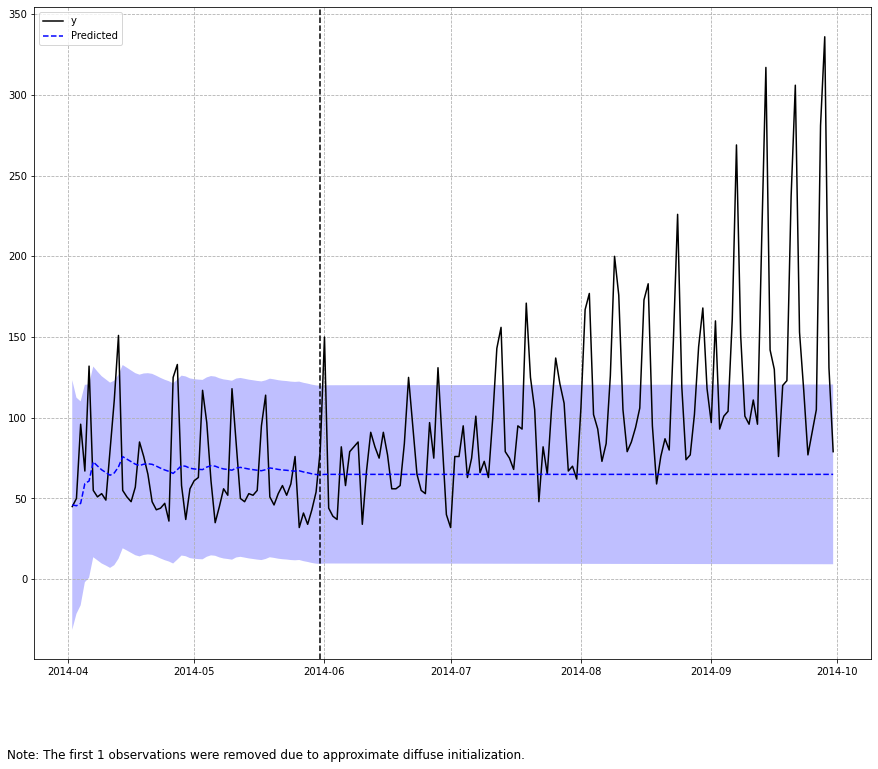

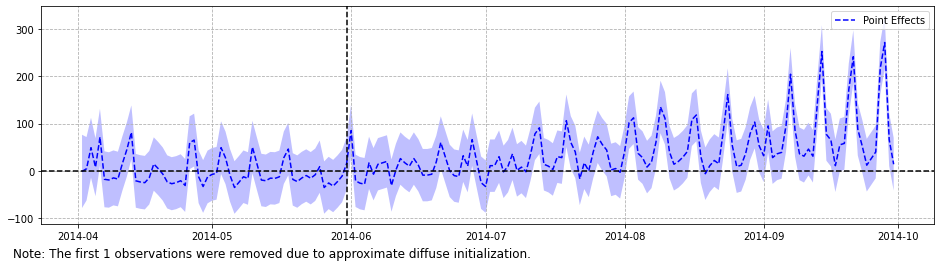

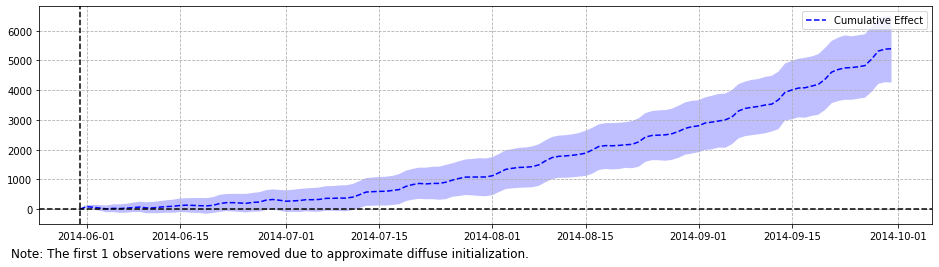

In [184]:
# #Using Causal Impact analysis, the three parameter you should fill (data, pre-intervention time, post-intervention time)
ci = CausalImpact(dated_data, pre_period, post_period)

ci.plot(panels=['original'])
ci.plot(panels=['pointwise'], figsize=(16,4))
ci.plot(panels=['cumulative'], figsize=(16,4))

In [185]:
print(ci.summary())
print(ci.summary(output='report'))

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    109.15             13316.0
Prediction (s.d.)         64.94 (4.67)       7922.29 (569.62)
95% CI                    [55.96, 74.26]     [6826.69, 9059.56]

Absolute effect (s.d.)    44.21 (4.67)       5393.71 (569.62)
95% CI                    [34.89, 53.19]     [4256.44, 6489.31]

Relative effect (s.d.)    68.08% (7.19%)     68.08% (7.19%)
95% CI                    [53.73%, 81.91%]   [53.73%, 81.91%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 109.15. By contrast, in the absence of an
intervention, we would have expected an average response of 64.94.
The 95% interval of this counterfactual prediction is [55.96, 74.26].
Subtracting this predictio

## Análisis campaña #2
En cuanto a la segunda promoción, se seleccionó Brooklyn como zona de pruebas, en donde se han aplicado reducciones de precio a los viajes de UberPool desde agosto hasta septiembre.

### Modelamiento mediante series de tiempo bayesianas

In [196]:
dated_data2 = datos_cmp2.set_index(pd.date_range(start='20140401', periods=len(datos_cmp2)))
dated_data2.head()

# #Time period for pre-intervention and post-intervention
pre_period = ['20140401', '20140731']
post_period = ['20140801', '20140930']

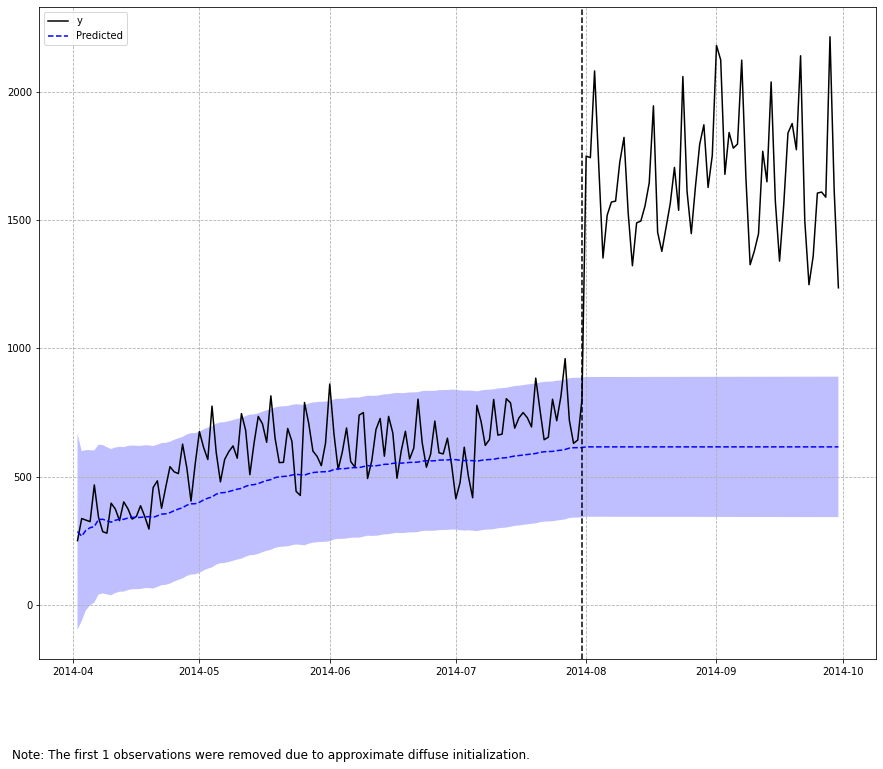

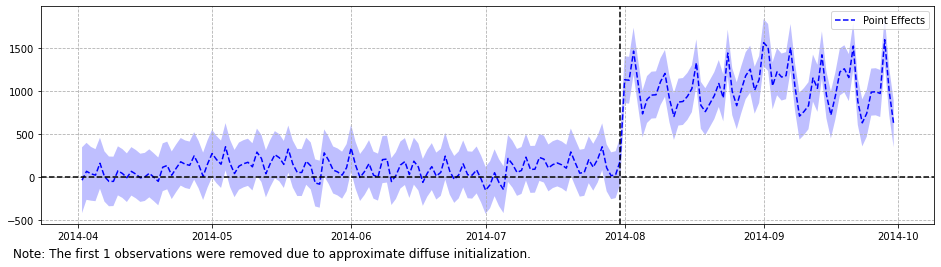

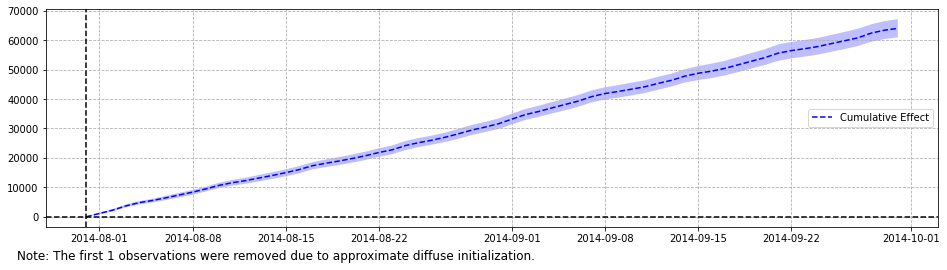

In [197]:
# #Using Causal Impact analysis, the three parameter you should fill (data, pre-intervention time, post-intervention time)
ci = CausalImpact(dated_data2, pre_period, post_period)

ci.plot(panels=['original'])
ci.plot(panels=['pointwise'], figsize=(16,4))
ci.plot(panels=['cumulative'], figsize=(16,4))

In [198]:
print(ci.summary())
print(ci.summary(output='report'))

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1665.43            101591.0
Prediction (s.d.)         616.28 (25.92)     37593.23 (1581.19)
95% CI                    [564.78, 666.39]   [34451.79, 40649.92]

Absolute effect (s.d.)    1049.14 (25.92)    63997.77 (1581.19)
95% CI                    [999.03, 1100.64]  [60941.08, 67139.21]

Relative effect (s.d.)    170.24% (4.21%)    170.24% (4.21%)
95% CI                    [162.11%, 178.59%] [162.11%, 178.59%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1665.43. By contrast, in the absence of an
intervention, we would have expected an average response of 616.28.
The 95% interval of this counterfactual prediction is [564.78, 666.39].
Subtractin